In [1]:
import glob

import dask.distributed
import matplotlib.pyplot as plt
import ncar_jobqueue
import xarray as xr

import utils
from utils.utils import time_set_mid

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
casename = "g.e22.G1850ECO_JRA_HR.TL319_t13.003"

In [3]:
cluster = ncar_jobqueue.NCARCluster(
    cores=2, memory="64 GB", processes=2, walltime="6:00:00"
)
cluster.scale(n=8)  # n = number of workers
print(f"dashboard_link={cluster.dashboard_link}")
client = dask.distributed.Client(cluster)

/glade/work/mlevy/miniconda3/envs/hires-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


dashboard_link=https://jupyterhub.ucar.edu/dav/user/mlevy/proxy/35431/status


In [4]:
case = utils.CaseClass(casename)
stream = "pop.h"
varnames = ["PO4", "NO3", "SiO3", "O2", "DIC", "ALK"]
ds_4d = case.gen_dataset(
    varnames,
    stream,
    start_year=2,
    end_year=4,
)

Datasets contain a total of 36 time samples
Last average written at 0005-01-01 00:00:00


In [5]:
za_dir = f"/glade/scratch/klindsay/{casename}/ocn/proc"
filename_pattern = f"{za_dir}/za_{casename}.pop.h.????-??.nc"
za_filenames = glob.glob(filename_pattern)
za_filenames.sort()
ds_tmp = xr.open_mfdataset(
    za_filenames[12:48],
    data_vars="minimal",
    compat="override",
    coords="minimal",
)
ds_za = time_set_mid(ds_tmp, "time").assign_coords(
    {"basins": ["Global", "Pacific", "Indian", "Atlantic"]}
)

In [6]:
def trend_plots(varname, map_vminmax=None, za_vminmax=None):
    da = ds_4d[varname][:, 28, :, :]
    da = da.chunk({"time": -1, "nlat": 300, "nlon": 900})
    utils.trend_plot(da, vmin=-map_vminmax, vmax=map_vminmax)

    for basin_ind in range(ds_za.dims["basins"]):
        da = ds_za[varname].isel(basins=basin_ind)
        da = da.chunk({"time": -1, "z_t": 10, "lat_t": 300})
        utils.trend_plot(
            da, vmin=-za_vminmax, vmax=za_vminmax, invert_yaxis=True
        )

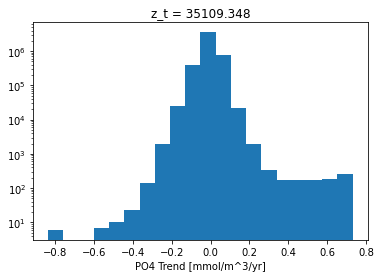

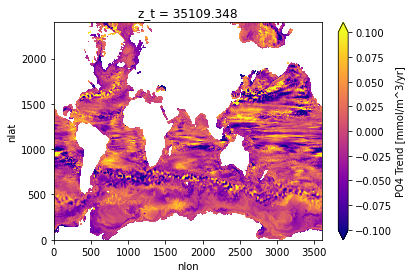

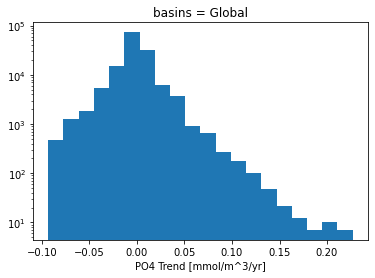

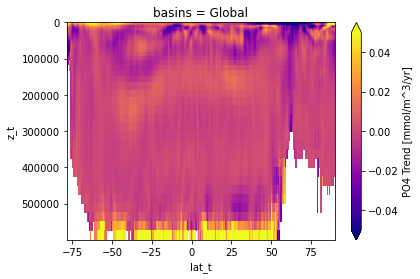

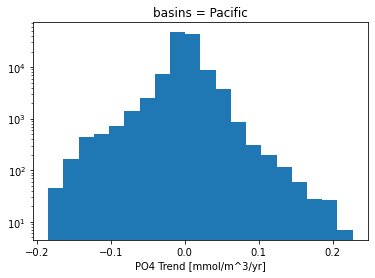

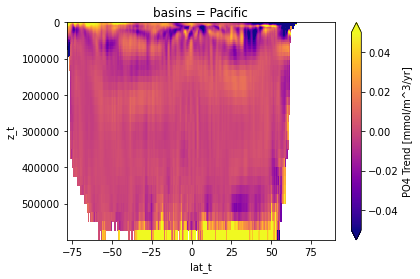

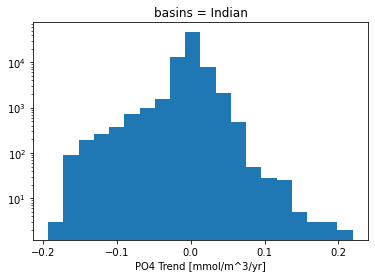

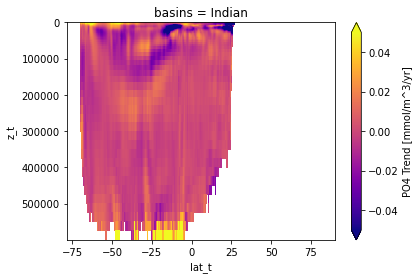

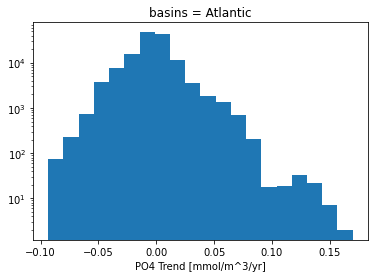

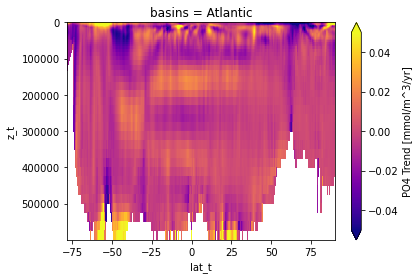

In [7]:
trend_plots("PO4", map_vminmax=0.1, za_vminmax=0.05)

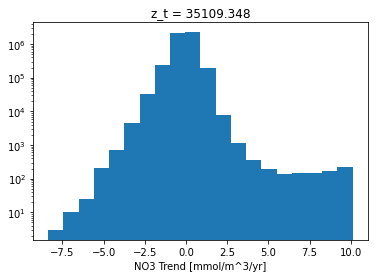

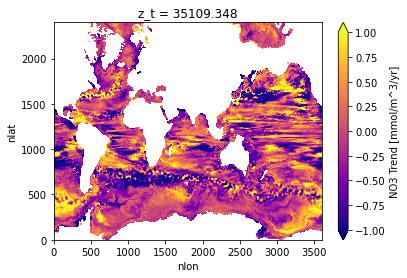

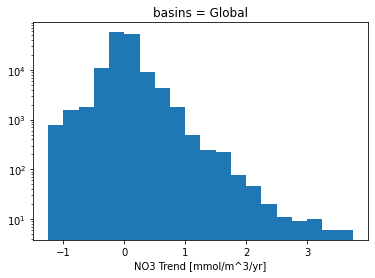

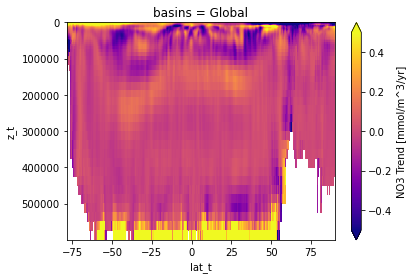

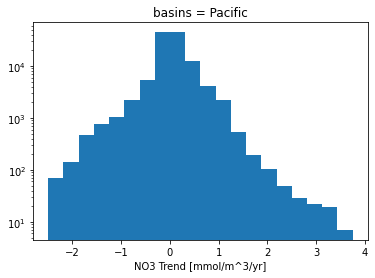

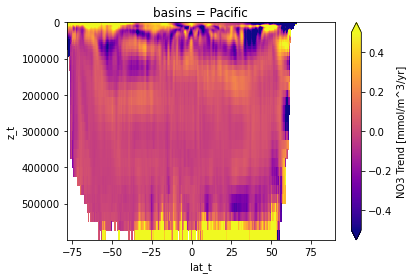

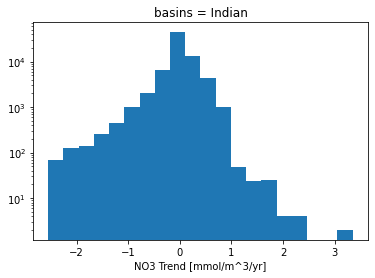

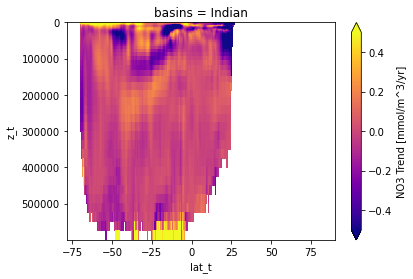

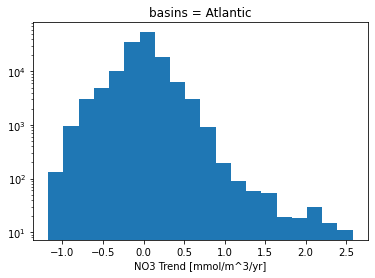

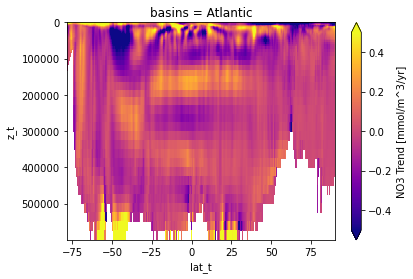

In [8]:
trend_plots("NO3", map_vminmax=1.0, za_vminmax=0.5)

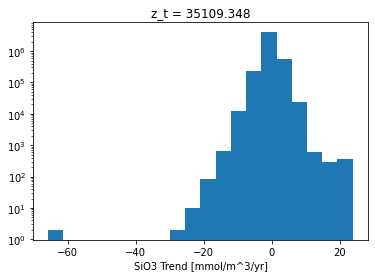

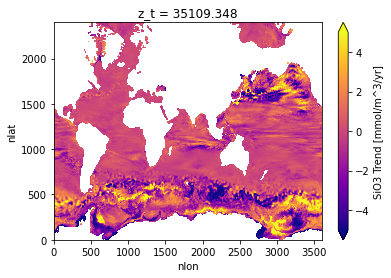

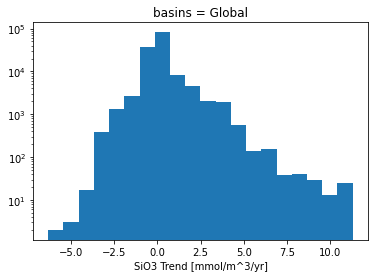

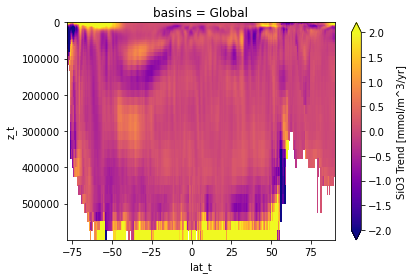

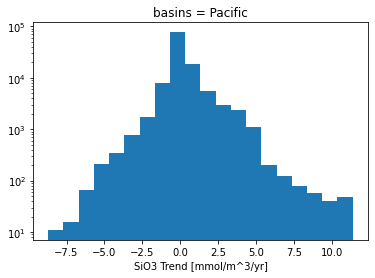

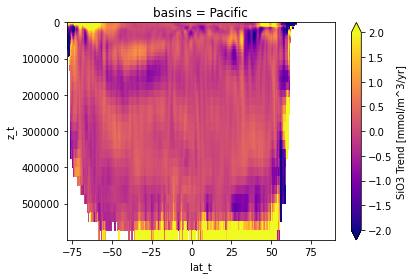

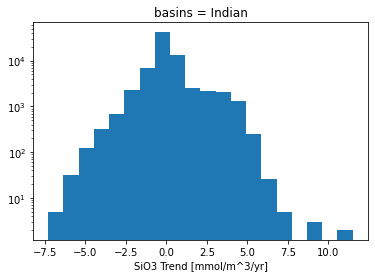

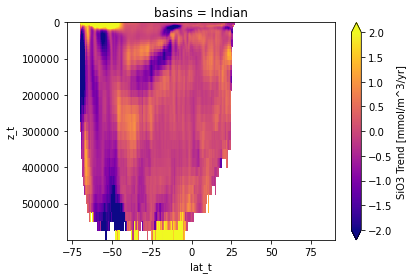

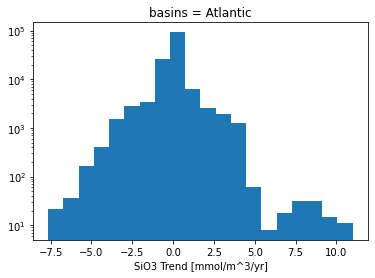

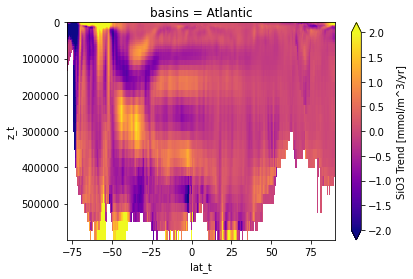

In [9]:
trend_plots("SiO3", map_vminmax=5.0, za_vminmax=2.0)

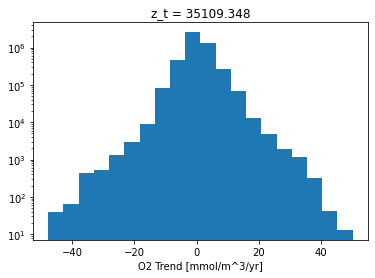

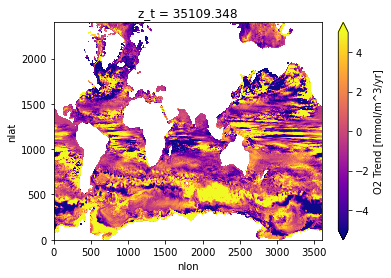

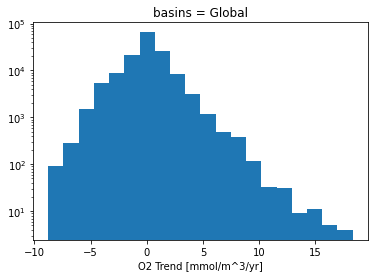

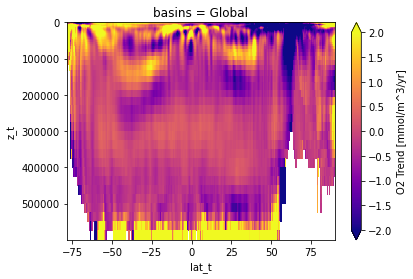

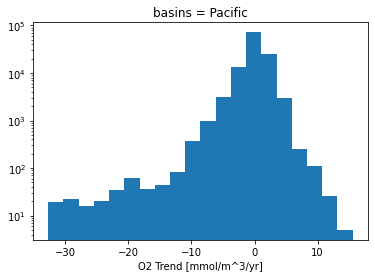

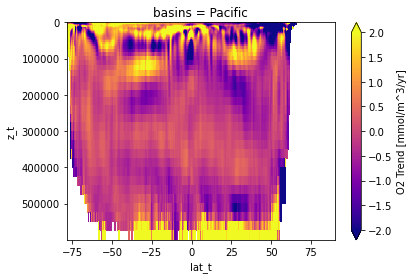

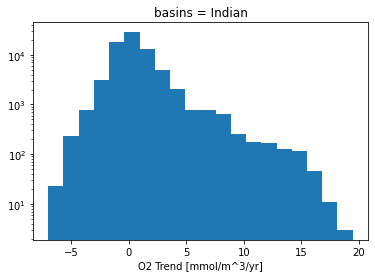

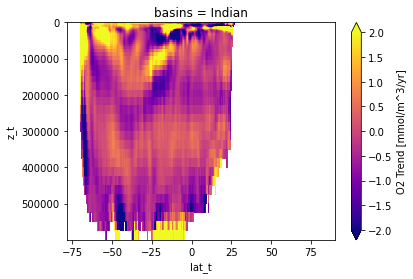

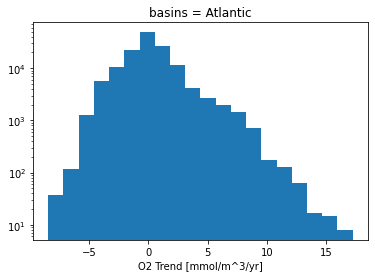

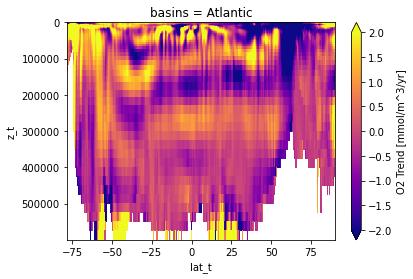

In [10]:
trend_plots("O2", map_vminmax=5.0, za_vminmax=2.0)

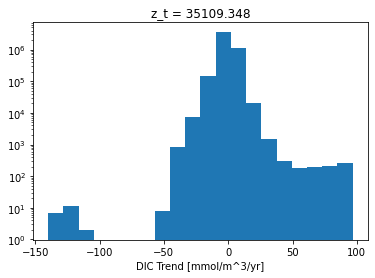

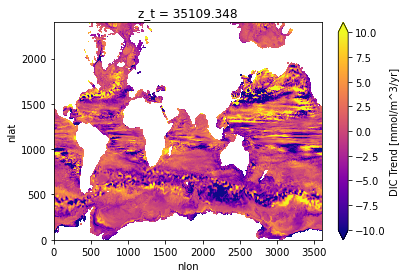

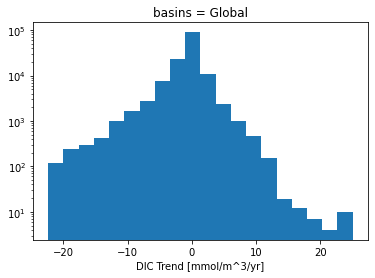

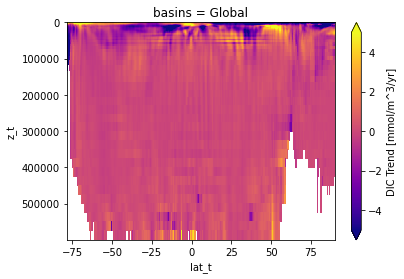

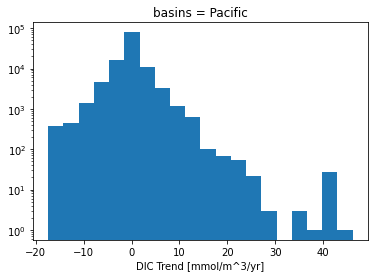

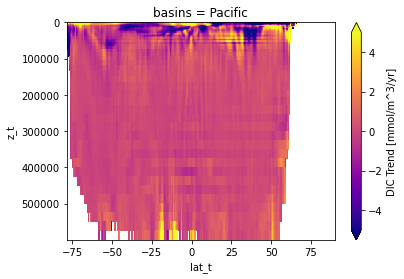

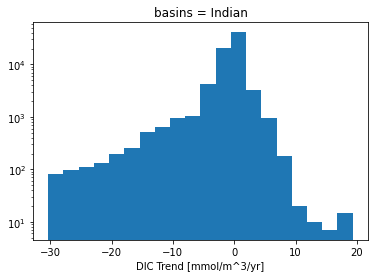

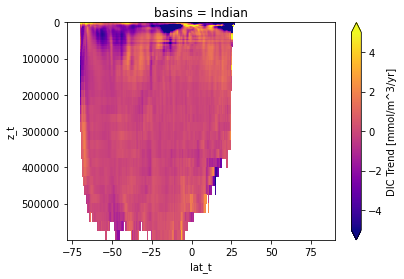

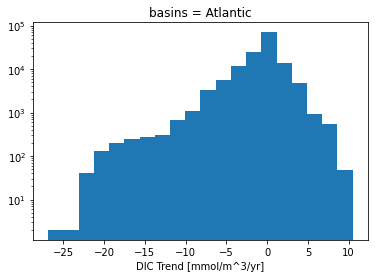

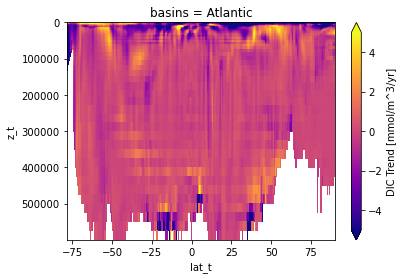

In [11]:
trend_plots("DIC", map_vminmax=10.0, za_vminmax=5.0)

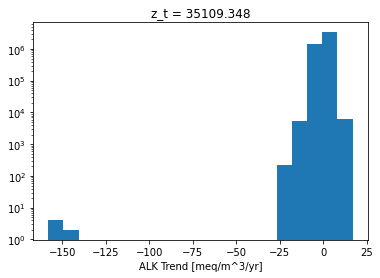

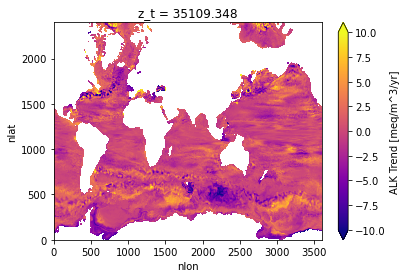

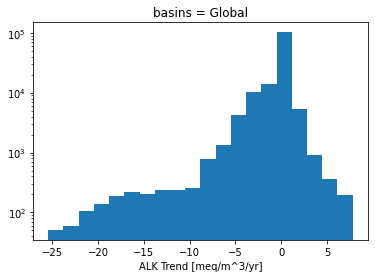

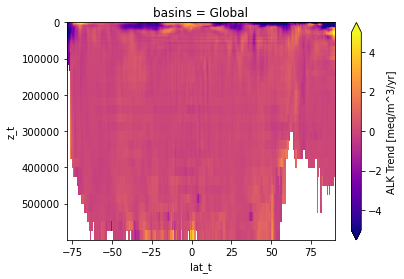

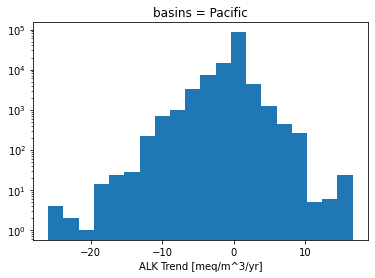

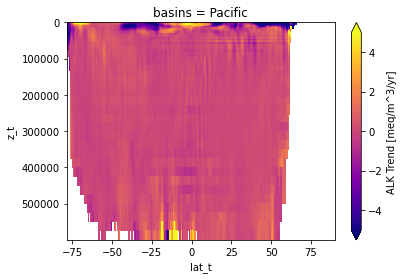

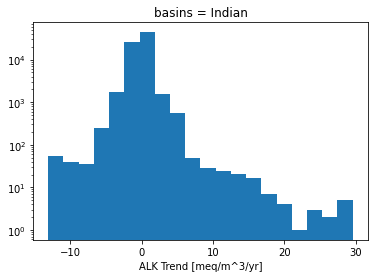

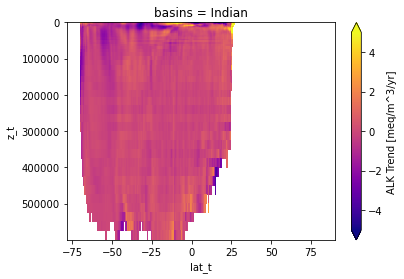

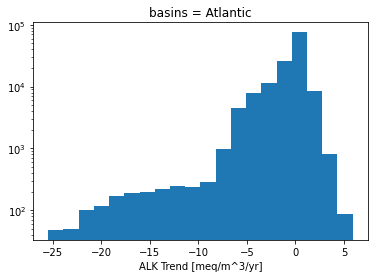

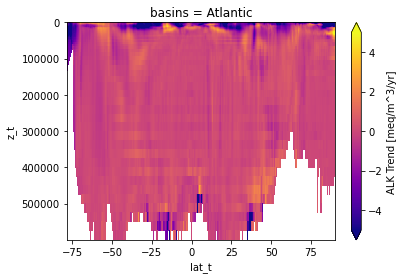

In [12]:
trend_plots("ALK", map_vminmax=10.0, za_vminmax=5.0)

In [13]:
client.close()
cluster.close()